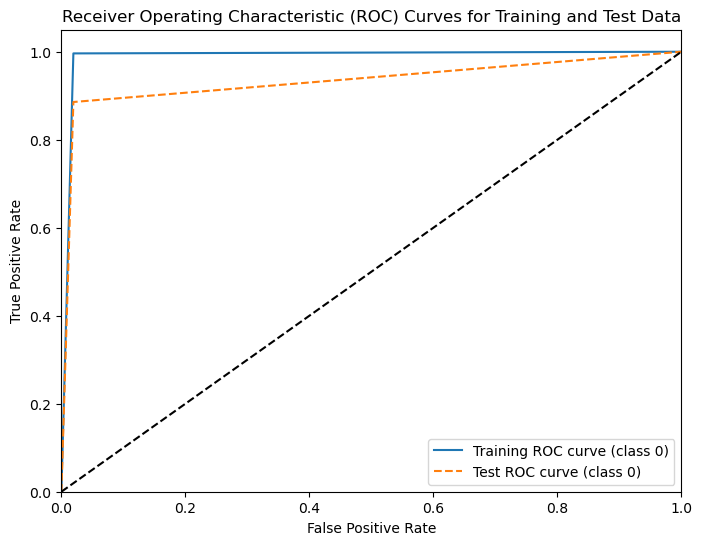

In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load your resampled training dataset and test dataset
train_data = pd.read_csv("C:/Users/DELL/Documents/myNewDataSet/ProcessedData.csv")
test_data = pd.read_csv("C:/Users/DELL/Documents/myNewDataSet/ProcessedData.csv")

# Separate features and target for both training and test datasets
X_train = train_data.drop(columns=["Perinatal_Death"])
y_train = train_data["Perinatal_Death"]
X_test = test_data.drop(columns=["Perinatal_Death"])
y_test = test_data["Perinatal_Death"]

# Initialize SMOTE for the training dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Feature selection using SelectKBest and ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=10)  # Adjust k as needed
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test)

# Train a Random Forest classifier on selected features
clf.fit(X_train_selected, y_train_resampled)

# Make predictions on both training and test sets
y_train_pred = clf.predict(X_train_selected)
y_test_pred = clf.predict(X_test_selected)

# Generate ROC Curve for multiclass on both training and test sets
y_train_bin = label_binarize(y_train_resampled, classes=[10, 20])
y_test_bin = label_binarize(y_test, classes=[10, 20])
y_train_pred_bin = label_binarize(y_train_pred, classes=[10, 20])
y_test_pred_bin = label_binarize(y_test_pred, classes=[10, 20])
n_classes = y_train_bin.shape[1]

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(n_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_pred_bin[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])
    
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC Curves for both training and test sets
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr_train[i], tpr_train[i], label=f'Training ROC curve (class {i})')
    plt.plot(fpr_test[i], tpr_test[i], linestyle='--', label=f'Test ROC curve (class {i})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Training and Test Data')
plt.legend(loc="lower right")
plt.show()